# Using the Custom Hardware Image Generator

This notebook demonstrates hardware generation of an image stream and displaying it on the HDMI output. Before running it you will need to compile the example overlay with the frame generator in Verilog. Two files are generated:
- a `.bit` file, containing the FPGA configuration bitstream
- a `.hwh` (hardware handoff) file, containing information about the module heirarchy and memory map

Copy both files to the user home directory on the Pynq operating system. Then load them (loading the `.bit` also reads the `.hwh` of the same name):

In [ ]:
from pynq import Overlay
from pynq.lib.video import *

overlay = Overlay("/home/xilinx/32_bit_zoom_2.bit")

#pixgen.register_map.gp0 = 0x1234
#print(pixgen.register_map.gp0)

# Which registers holding which pixels // gpo: zoom, gp1: max_iter, gp2: x_offset, gp3: y_offset 






The overlay object is automatically configured with a Python attribute structure that allows you to access the hardware as Python objects. Appropriate driver classes are instantiated where a hardware block is recognised by the Pynq library. Here we get a convenient handle to the VDMA connected to the pixel generator:

In [ ]:
imgen_vdma = overlay.video.axi_vdma_0.readchannel

Next, the image generator DMA is configured and started:

In [ ]:
videoMode = common.VideoMode(640, 480, 24)
imgen_vdma.mode = videoMode
imgen_vdma.start()

The VDMA continuously reads frames into a cycle of memory buffers. You can take software ownership of a frame and get a NumPy handle for it:

In [ ]:
# Optional Debugging

print("Running:", imgen_vdma.running)
print("Started:", imgen_vdma.readchannel.running)
print("State:", imgen_vdma.readchannel.state)

Running: True


AttributeError: 'S2MMChannel' object has no attribute 'readchannel'

The frame can be displayed in the notebook using PiL:

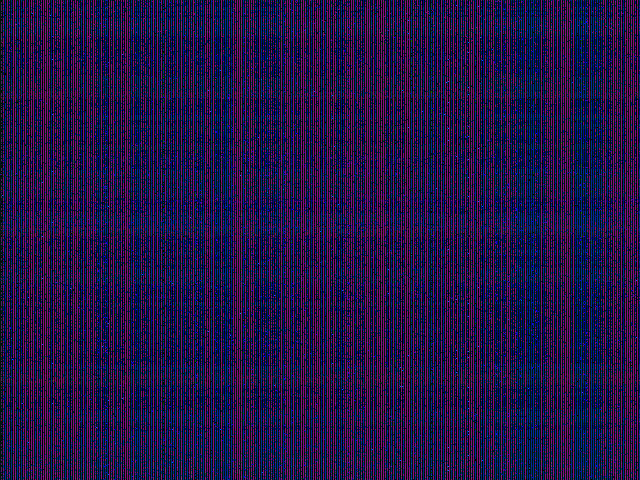

In [ ]:
# Ed Stott test code

from pynq import Overlay
from pynq.lib.video import *
import PIL.Image

overlay = Overlay("/home/xilinx/Kevin's_attempt.bit")
pg_vdma = overlay.video.axi_vdma_0
videoMode = common.VideoMode(640, 480, 24)
pg_vdma.readchannel.mode = videoMode
pg_vdma.readchannel.start()

frame = pg_vdma.readchannel.readframe()
image = PIL.Image.fromarray(frame)
image


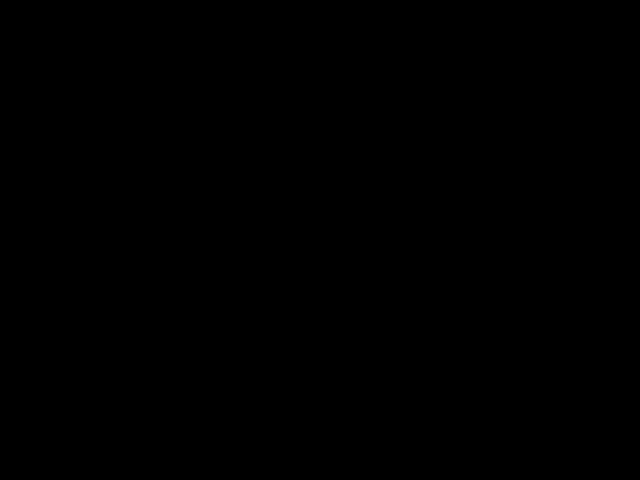

In [ ]:
import PIL.Image
frame = imgen_vdma.readframe()
image = PIL.Image.fromarray(frame, 'RGB')
#print(frame)
image

# 

Matplotlib is building the font cache; this may take a moment.


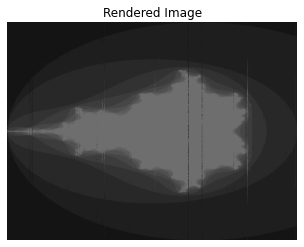

Saved to image_pixels.csv


/home/xilinx/jupyter_notebooks/image_pixels.csv

In [ ]:
import PIL.Image
import numpy as np
import csv
import os

# Optional: Display inline image
from IPython.display import display, FileLink
import matplotlib.pyplot as plt

# --- Load or define the frame ---
# Assuming `frame` is already a NumPy array
image = PIL.Image.fromarray(frame)
pixels = np.array(image)

# Optional display
plt.imshow(image)
plt.title("Rendered Image")
plt.axis('off')
plt.show()

# --- Save as CSV ---
output_csv = "image_pixels.csv"

with open(output_csv, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)

    if pixels.ndim == 2:  # Grayscale
        for row in pixels:
            writer.writerow(row.tolist())

    elif pixels.ndim == 3 and pixels.shape[2] == 3:  # RGB
        for row in pixels:
            writer.writerow([f"{r},{g},{b}" for r, g, b in row])

    else:
        raise ValueError("Unsupported image shape")

print(f"Saved to {output_csv}")

# --- Show download link in Jupyter ---
display(FileLink(output_csv))




### HDMI Output
The HDMI output is handled with a wrapper object that configures both the VDMA and the HDMI output generator.

A bit of hacking is needed here: the image generator and its VDMA are in the same part of the design hierarchy (`video`) as the HDMI interface. The HDMI output wrapper `overlay.video.hdmi_out` picks up the image generator VDMA, not the one connected to HDMI, so that attribute needs to be changed to point to the correct VDMA.

After that, the HDMI output is configured and started:

In [ ]:
hdmi_out = overlay.video.hdmi_out
hdmi_out._vdma = overlay.video.axi_vdma #Use the correct VDMA!
hdmi_out.configure(videoMode)
hdmi_out.start()

Now our frame can be sent to the HDMI output. At this stage ownership of the frame is transferred to the hardware, so it's no longer accessible to Python code. Connect a display to the HDMI port and you should see it.

In [ ]:
# while True:
#     frame = imgen_vdma.readframe()
hdmi_out.writeframe(frame)

### MMIO Interface with Pixel Generator
You'll need to pass parameters to your image generator to change the visualisation at runtime. This is done with memory-mapped input/output, which allows software to modify registers in the logic. First get a handle to the Pixel Generator block and print its dictionary of registers:

In [ ]:
pixgen = overlay.pixel_generator_0
pixgen.register_map

RegisterMap {
  gp0 = Register(value=0),
  gp1 = Register(value=0),
  gp2 = Register(value=0),
  gp3 = Register(value=0),
  gp4 = Register(value=0),
  gp5 = Register(value=0),
  gp6 = Register(value=0),
  gp7 = Register(value=0)
}

The registers can be modified directly as Python objects

In [ ]:
import PIL.Image
import time

# pixgen.register_map.gp0 = 0x10
# print(pixgen.register_map.gp0)

# Which registers holding which pixels // gpo: zoom, gp1: max_iter, gp2: x_offset, gp3: y_offset 

pixgen = overlay.pixel_generator_0
# pixgen.register_map

max_iter = 1000
# zoom = 0x0002
real_center = 0xF4000000
imag_center = 0x0199999A

pixgen.register_map.gp0 = max_iter
pixgen.register_map.gp1 = 1
pixgen.register_map.gp2 = real_center
pixgen.register_map.gp3 = imag_center


num_steps = 1000

for i in range (1,num_steps):
    frame = imgen_vdma.readframe()
    image = PIL.Image.fromarray(frame)
    hdmi_out.writeframe(frame)
    
   # pixgen.register_map.gp1 = i

KeyboardInterrupt: 

Data that you write to register `n` is is available in `regfile[n]` in your logic

### Cleanup
Finally, stop the VDMAs so that the system is in a stable state at the end of the notebook

In [ ]:
imgen_vdma.stop()
hdmi_out.close()

Todo:
- [ ] Copy multiple frames and find frame rate
- [ ] Link input and output for continuous video output without software control